First, we import the necessary packages and load our data into a dataframe. 

In [3]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Project 2/1028_2124_bundle_archive/Shakespeare_data.csv'
rawData = pd.read_csv(filepath, delimiter = ',')

We examine the data and notice that there are entries like "Act 1" and "Scene 1" that do not have player line entry. We wish to remove those. 

In [4]:
data = rawData.dropna()

Next, I was interested to see how many different players there were, so I created a list of the different players.

In [7]:
players = data.Player.unique().tolist()
print(len(players))

934


We now move onto feature engineering. The first feature we're interested in adding is a column to indicate the length of the line. 

In [8]:
noWords = []
for index, row in data.iterrows():
    noWords.append(len(row['PlayerLine'].split()))
    
data['NumWords'] = noWords

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Next, we are interested in creating new columns to indicate whether popular words are included in the line. To do so, we will count the instances of all the words and take the 50 most used ones. Then, we create a new variable for each of these 50 words with a count of that word for the given line. 

In [9]:
wordCount = {}
for index, row in data.iterrows():
    line = row['PlayerLine'].translate(str.maketrans('', '', string.punctuation)).lower()
    words = line.split()
    for word in words:
        if word not in wordCount:
            wordCount[word] = 0
        wordCount[word] += 1
        
sorted_wordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
#top 50 words
top_words50 = sorted_wordCount[:50]

To get a sense of the top 50 words, we create a bar chart with the top 50 words and their instances:

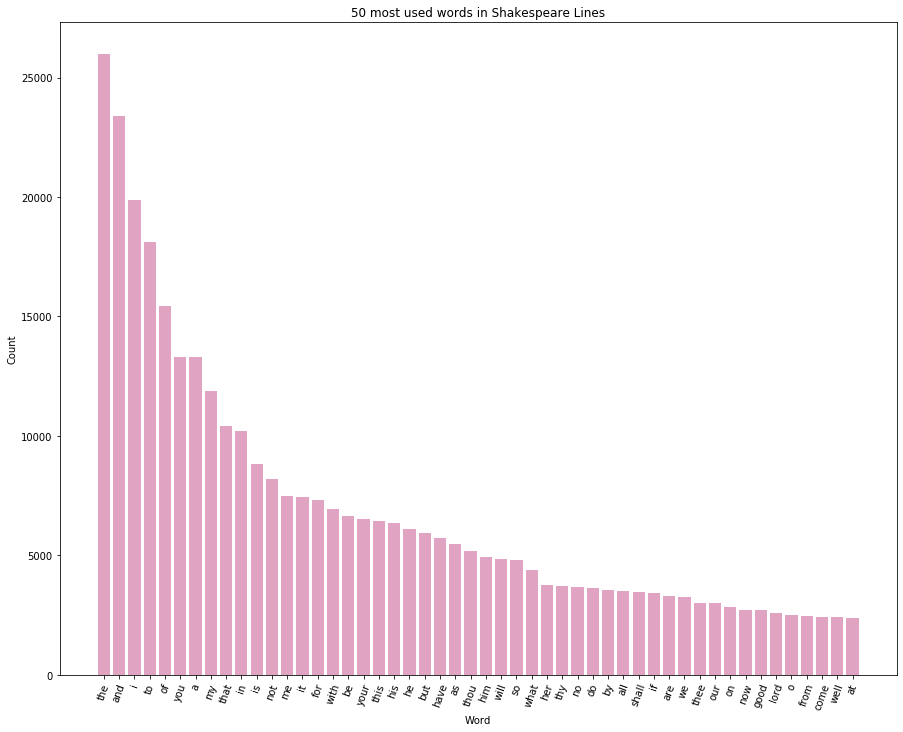

In [17]:
plt.figure(figsize=(15,12))
plt.bar(range(len(top_words50)), [val[1] for val in top_words50], align='center', color=(0.8, 0.4, 0.6, 0.6))
plt.xticks(range(len(top_words50)), [val[0] for val in top_words50])
plt.xticks(rotation=70)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('50 most used words in Shakespeare Lines')
plt.draw()

As we said, we want to create a new column in our dataframe for each of these words to count the instances of the word in the given line.

In [18]:
columns = {}
for word in top_words50:
    columns[word[0]] = [0 for _ in range(len(noWords))]

i=0   
for index, row in data.iterrows():
    line = row['PlayerLine'].translate(str.maketrans('', '', string.punctuation)).lower()
    words = line.split()
    for word in words:
        if word in columns:
            columns[word][i] += 1
    i+=1
    
for word in top_words50:
    data[word[0] + '_count'] = columns[word[0]]

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Now that we have some added features in our dataset, we are ready to preprocess the text in order to run it in our classifier. We will use CountVectorizer to transform our lines into sparse matrices, and then transform them to arrays and concatonate them on our dataframe.

In [19]:
labels = data['Player']
data_playerLine = data['PlayerLine']
data_x = data.drop(['Player', 'Dataline', 'Play','ActSceneLine', 'PlayerLine'], axis=1)

cv = CountVectorizer(binary = False, max_df = .95)
cv.fit_transform(data_playerLine)
data_playerLineTransform = cv.transform(data_playerLine.values)
playerArray = data_playerLineTransform.toarray()
playerDF = pd.DataFrame(np.row_stack(playerArray))

fullData_x = pd.concat([data_x, playerDF.set_index(data_x.index)], axis=1)

We now create our train and test datasets. We use a 80/20 split.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(fullData_x, labels, test_size=0.2, random_state=0)

Our data is now ready for classification. The first classifier we are going to investigate is a Logistic Regression classifier. 

In [21]:
classifier = LogisticRegression()
classifier.fit(X_train,y_train)
score = classifier.score(X_test, y_test)
print(score)

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.08335314535685416


In [ ]:
sgd = SGDClassifier(loss = 'modified_huber', shuffle = True, random_state=101)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
score = sgd.score(X_test, y_test)
print(score)

This model took a very long time to compile and we didn't get an accuracy from it. However, based on the logistic regression classifier it wouldn't be very good. I then moved onto a different strategy. (see Notebook 2) 